# Transformation des données

### rechargement des packages et autres trucs dont pickles

In [72]:
import pandas as pd
import os
import json
import glob
import sqlite3, sqlalchemy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [5]:
#lire le fichier json des paramètres 
with open('../parameters.json') as json_data:
    params = json.load(json_data)
    
DATA_DIR = params['DIRECTORIES']['DATA_DIR']
TMP_DIR = params['DIRECTORIES']['TMP_DIR']
PRICE_FILE = params['FILES']['PRICE_FILE']
STATION_FILE = params['FILES']['STATION_FILE']
SERVICE_FILE = params['FILES']['SERVICE_FILE']
#ici on en profite pour faire tt de suite le path os join
GAS_DB = os.path.join(DATA_DIR, params['DATABASES']['GAS_DB'])

In [6]:
dfall = pd.read_pickle(os.path.join(DATA_DIR,PRICE_FILE))
dfservices = pd.read_pickle(os.path.join(DATA_DIR,SERVICE_FILE))
dfstations = pd.read_pickle(os.path.join(DATA_DIR,STATION_FILE))

In [8]:
#conversion de la date
dfall['date_releve'] = pd.to_datetime(dfall.date_releve)

### Calcul de l'indice de prix hebdo

In [13]:
#moyenne du prix par semaine par station
(dfall
 .dropna(subset=['date_releve'])
 .groupby(['id_station','libelle_carburant', pd.Grouper(key='date_releve', freq='1W')])
 .agg({'prix':np.mean})
).head()
#on voit que l'index est ocmposé de plusieurs colonne, c'est une clé poru identifier de façon unique chacune des lignes

prix
id_station libelle_carburant date_releve        
1000001    E10               2015-02-08   1309.0
           Gazole            2014-01-05   1304.0
                             2014-01-12   1304.0
                             2014-01-19   1304.0
                             2014-01-26   1304.0

In [21]:
#moyenne du prix par semaine par station. On reset l'index vu qu'on va merge par colonne plutot que par index
moyenne_hebdo_df = (dfall
 .dropna(subset=['date_releve'])
 .groupby(['libelle_carburant', pd.Grouper(key='date_releve', freq='1W-MON')])
 .agg({'prix':np.mean})
 .reset_index()                 
)

In [23]:
moyenne_hebdo_df.head()

,libelle_carburant,date_releve,prix
0,E10,2014-01-06,1490.073267
1,E10,2014-01-13,1486.280544
2,E10,2014-01-20,1476.317653
3,E10,2014-01-27,1477.604423
4,E10,2014-02-03,1479.143865


In [26]:
#moyenne du prix par semaine et par station merged avec prix par semaine aggrégé
#assign pour calculer nouvelel variable dans le merge
model_df = (dfall
 .dropna(subset=['date_releve'])
 .groupby(['id_station','libelle_carburant', pd.Grouper(key='date_releve', freq='1W-MON')])
 .agg({'prix':np.mean})
 .reset_index()
 .merge(moyenne_hebdo_df,how='inner',on=['libelle_carburant','date_releve'],suffixes=('','_moyen'))
 .assign(indice=lambda df: df.prix/df.prix_moyen)
)

In [27]:
model_df.shape

(3240069, 6)

In [30]:
model_df.head()

,id_station,libelle_carburant,date_releve,prix,prix_moyen,indice
0,1000001,E10,2015-02-09,1309.000000,1308.978319,1.000017
1,1000007,E10,2015-02-09,1269.800000,1308.978319,0.970070
2,1000008,E10,2015-02-09,1272.333333,1308.978319,0.972005
3,1000009,E10,2015-02-09,1267.500000,1308.978319,0.968312
4,1100001,E10,2015-02-09,1274.000000,1308.978319,0.973278


In [32]:
model_df.indice.describe()

count    3.240069e+06
mean     1.003950e+00
std      4.760333e-02
min      1.433224e-03
25%      9.740281e-01
50%      9.902849e-01
75%      1.030610e+00
max      2.051147e+00
Name: indice, dtype: float64

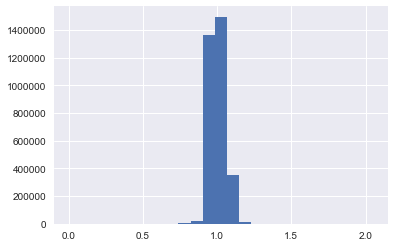

In [29]:
model_df.indice.hist(bins=25)

### Construction du vecteur de services

In [36]:
#on veut pas spliter sur l'espace mais sur la virgule. 
_tokenize = lambda x: x.split(',')
#par défaut le vectorizer va tout convertir en minuscules (lowercase=True)
vectorize = CountVectorizer(tokenizer=_tokenize,lowercase=False)

In [48]:
#créer un dataframe à partir de notre transformation appliqués sur la variable services de dfservices
    #on utilisera l'index de dfservices
    #on recupere les noms de colonne
    #valeur par défaut = 0, sinon on aurait NaN à la place. 
matrice_services_df = pd.SparseDataFrame(vectorize.fit_transform(dfservices.services.fillna('Rien')),
                  dfservices.id_station,
                  vectorize.get_feature_names(),
                  default_fill_value=0
                  ).reset_index()

In [49]:
matrice_services_df.head()

,id_station,Aire de camping-cars,Automate CB,Baie de service auto,Bar,Boutique alimentaire,Boutique non alimentaire,Carburant qualité supérieure,Douches,Espace bébé / change,...,Relais colis,Restauration sur place,Restauration à emporter,Rien,Station de gonflage,Station de lavage,Toilettes publiques,Vente de fioul domestique,Vente de gaz domestique,Vente de pétrole lampant
0,1000001,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,1000002,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1000004,0,0,0,0,1,1,1,0,0,...,1,0,0,0,1,0,1,1,1,0
3,1000005,0,1,0,0,1,1,1,0,0,...,0,0,0,0,1,1,0,0,1,0
4,1000006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [50]:
#merge le table avec indice prix avec celle qui a la matrice des services
model_services_df = model_df.merge(matrice_services_df,how='inner', on=['id_station'])

In [ ]:
#model_df.merge(matrice_services_df,how='outer', on=['id_station'])

### Modelisation (regression linéaire)

In [51]:
lr = LinearRegression()

In [57]:
#fit du modele avec les variables X pour entrainer et le y c'est l'indice des prix, ce qu'on cherche à modeliser
lr.fit(X=model_services_df[list(set(matrice_services_df.columns)-{'id_station'})],
       y=model_services_df.indice)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [58]:
lr.coef_

array([-0.00761309,  0.01834778,  0.00243954, -0.00748809, -0.00047572,
       -0.0002079 , -0.00135688, -0.01879372, -0.0079994 , -0.0130757 ,
       -0.00375147, -0.01496684, -0.00086467, -0.00807226,  0.00500321,
        0.00945038,  0.01838106,  0.00700189, -0.01345772,  0.04518087,
       -0.00731001, -0.00360002,  0.00127529,  0.01417165,  0.00573528])

In [66]:
#zip associe deux listes. 
resultats = pd.DataFrame(
    [(f,c) for f, c in zip(list(set(matrice_services_df.columns)-{'id_station'}),lr.coef_)],
    columns=['Service','Coefficient']).sort_values('Coefficient', ascending = False)
                         

In [67]:
resultats

,Service,Coefficient
19,Douches,0.045181
16,Toilettes publiques,0.018381
1,Baie de service auto,0.018348
23,Carburant qualité supérieure,0.014172
15,Station de gonflage,0.009450
17,Espace bébé / change,0.007002
24,Boutique non alimentaire,0.005735
14,Vente de fioul domestique,0.005003
2,Relais colis,0.002440
22,Lavage haute-pression,0.001275


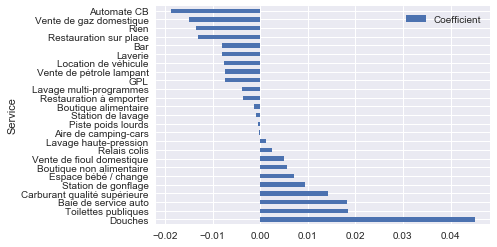

In [70]:
resultats.set_index('Service').plot(kind='barh')

### Modelisation (random forest)

In [73]:
rf = RandomForestRegressor()

In [74]:
rf.fit(X=model_services_df[list(set(matrice_services_df.columns)-{'id_station'})],
       y=model_services_df.indice)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [77]:
rf.feature_importances_

array([  2.20626112e-02,   6.57683516e-02,   1.38142421e-02,
         1.16448025e-02,   2.63038265e-02,   9.19054534e-03,
         1.78692451e-02,   1.24721548e-01,   7.20317448e-03,
         2.20324790e-02,   2.16200515e-02,   6.46845190e-02,
         2.19672681e-02,   1.44729659e-02,   2.11544883e-02,
         2.14315050e-02,   3.26512050e-02,   1.92265526e-02,
         5.84743584e-05,   2.02232556e-01,   2.71691404e-02,
         2.46480348e-02,   2.24035707e-02,   1.59698453e-01,
         2.59703899e-02])

In [82]:
resultats_rf = pd.DataFrame(
    [(f,c) for f, c in zip(list(set(matrice_services_df.columns)-{'id_station'}),rf.feature_importances_)],
    columns=['Service','Coefficient']).sort_values('Coefficient', ascending = False)

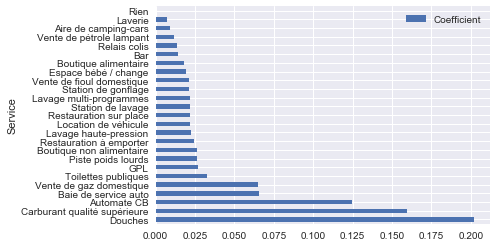

In [83]:
resultats_rf.set_index('Service').plot(kind='barh')